## Importing libraries and Dataset

In [13]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
from Phytopredictor import PhytoPredictor, aggregate_phyto_data, predict, train_phytopredictor, data_splitter

In [8]:
df = pd.read_excel('../../data/MERGED_DATA_180624.xlsx', sheet_name='MERGE_FINAL')
df.head()

,LOC_CODE,DATUM,TIJD,ZS [mg/l],ZICHT [dm],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],...,Pde,Plo,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,interpolated_columns
0,DANTZGT,1990-01-10,15:00:00,135.0,2.0,4.0,20.178571,29.19,1.645161,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,DANTZGT,1990-02-06,13:40:00,295.0,0.5,6.0,19.803571,27.37,1.177419,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['SiO2 [umol/L]', 'PO4 [umol/L]', 'pH [DIMSLS]..."
2,DANTZGT,1990-03-08,13:45:00,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,DANTZGT,1990-04-04,10:00:00,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,DANTZGT,1990-05-09,15:30:00,20.0,11.0,17.4,1.714286,33.28,1.161290,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


## Defining the different columns and preparing the dataframe

In [9]:

columns = list(df.columns)

abio_columns = ['ZS [mg/l]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]']
phyto_columns = ['Acn', 'Aco', 'Agl', 'Ata', 'Cau', 'Ccu', 'Cda',
       'Cdeb', 'Cden', 'Cdi', 'Cei', 'Cfu', 'Cgr', 'Cha', 'Coc', 'Cra', 'Csu',
       'Cwa', 'Dac', 'Dat', 'Dbr', 'Dip', 'Dle', 'Dno', 'Dpu', 'Dro', 'Dsp',
       'Edu', 'Etr', 'Ezo', 'Fja', 'Gde', 'Gfa', 'Gfl', 'Gsp', 'Hak', 'Hta',
       'Kgl', 'Lan', 'Lun', 'Mhe', 'Mnu', 'Mpe', 'Ndi', 'Nsc', 'Nsi', 'Oau',
       'Omo', 'Ore', 'Orh', 'Oro', 'Osi', 'Pac', 'Pan', 'Pba', 'Pbi', 'Pbr',
       'Pcl', 'Pco', 'Pde', 'Pha', 'Plo', 'Pmi', 'Pos', 'Pse', 'Pst', 'Psu',
       'Pte', 'Ptr', 'Ram', 'Rse', 'Rst', 'Rte', 'Stu', 'Tec', 'Tle', 'Tni',
       'Tno', 'Tor', 'Tro']
loc_date_columns = ["LOC_CODE", "DATUM"]

ignored_columns = set(df.columns) - set(loc_date_columns + abio_columns + phyto_columns)

df = df.drop(list(ignored_columns), axis=1)

# splitting the phytoplankton randomly for now
clusters = np.split(np.asarray(phyto_columns), 5)


## Aggregating the dataset using the clusterings

In [10]:
grouped_phyto_df, group_labels = aggregate_phyto_data(df, clusters)

grouped_phyto_df.head()

,LOC_CODE,DATUM,ZS [mg/l],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],NO3 [umol/L],NO2 [umol/L],NH4 [umol/L],E [/m],CHLFa [ug/l],group_0,group_1,group_2,group_3,group_4
0,DANTZGT,1990-01-10,135.0,4.0,20.178571,29.19,1.645161,7.8,37.571429,3.714286,14.071429,0.751180,1.3,46.713973,48.221006,44.913413,50.458967,52.410028
1,DANTZGT,1990-02-06,295.0,6.0,19.803571,27.37,1.177419,7.9,63.428571,2.892857,11.357143,11.391822,11.2,46.713973,48.221006,44.913413,50.458967,52.410028
2,DANTZGT,1990-03-08,103.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,1.364080,21.1,46.713973,48.221006,44.913413,50.458967,52.410028
3,DANTZGT,1990-04-04,113.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,1.037580,25.0,46.713973,48.221006,44.913413,50.458967,52.410028
4,DANTZGT,1990-05-09,20.0,17.4,1.714286,33.28,1.161290,8.3,0.214286,0.142857,1.928571,0.738760,10.2,48.111727,48.318009,43.834850,48.859339,53.866902


## Splitting the Dataframe for each Location

In [11]:
location_groups = grouped_phyto_df.groupby("LOC_CODE")

location_data_dict = {}
for name, loc_df in location_groups:
    
    loc_df = loc_df.drop(['DATUM', 'LOC_CODE'], axis=1)
    
    location_data_dict[name] = loc_df

for key, value in location_data_dict.items():
    print(f"{key}: {value.shape}")

DANTZGT: (598, 16)
DREISR: (584, 16)
GOERE6: (374, 16)
GROOTGND: (588, 16)
HANSWGL: (589, 16)
HUIBGOT: (588, 16)
LODSGT: (584, 16)
MARSDND: (590, 16)
NOORDWK10: (918, 16)
NOORDWK2: (580, 16)
NOORDWK20: (550, 16)
NOORDWK70: (550, 16)
ROTTMPT3: (289, 16)
ROTTMPT50: (210, 16)
ROTTMPT70: (210, 16)
SCHAARVODDL: (816, 16)
SOELKKPDOT: (584, 16)
TERSLG10: (542, 16)
TERSLG100: (461, 16)
TERSLG135: (462, 16)
TERSLG175: (373, 16)
TERSLG235: (372, 16)
TERSLG4: (288, 16)
VLISSGBISSVH: (690, 16)
WALCRN2: (373, 16)
WALCRN20: (371, 16)
WALCRN70: (371, 16)


## Training the Model

In [21]:
input_size_phyto = len(clusters)
input_size_abio = len(abio_columns)
lstm_hidden_size = input_size_phyto
ffnn_hidden_size = max(input_size_abio - 3, 5)
output_size = input_size_phyto
p_drop = 0.5
bidirectional = True

trial_name = "First Test"
shuffled_rows = True
random_seed = 5
train_ratio = 0.7
minimum_lookback = 10
lookback = -1
loss_metric = "MSE"
epochs = 5
check_interval = 10

# for now we just train for DANTZGT
data = location_data_dict["DANTZGT"]

model = PhytoPredictor(input_size_phyto, lstm_hidden_size, input_size_abio, ffnn_hidden_size, output_size, p_drop, bidirectional)

# optimiser is Adam for now, but can be changed
optimiser = Adam(model.parameters(), lr=0.001)

model, training_loss_log, evaluation_loss_log = train_phytopredictor(model, 
                                                                     optimiser, 
                                                                     data, 
                                                                     trial_name, 
                                                                     abio_columns, 
                                                                     group_labels, 
                                                                     shuffled_rows, 
                                                                     random_seed, 
                                                                     train_ratio, 
                                                                     minimum_lookback, 
                                                                     lookback, 
                                                                     loss_metric, 
                                                                     epochs,
                                                                     check_interval)

  0%|          | 0/2090 [00:00<?, ?it/s]

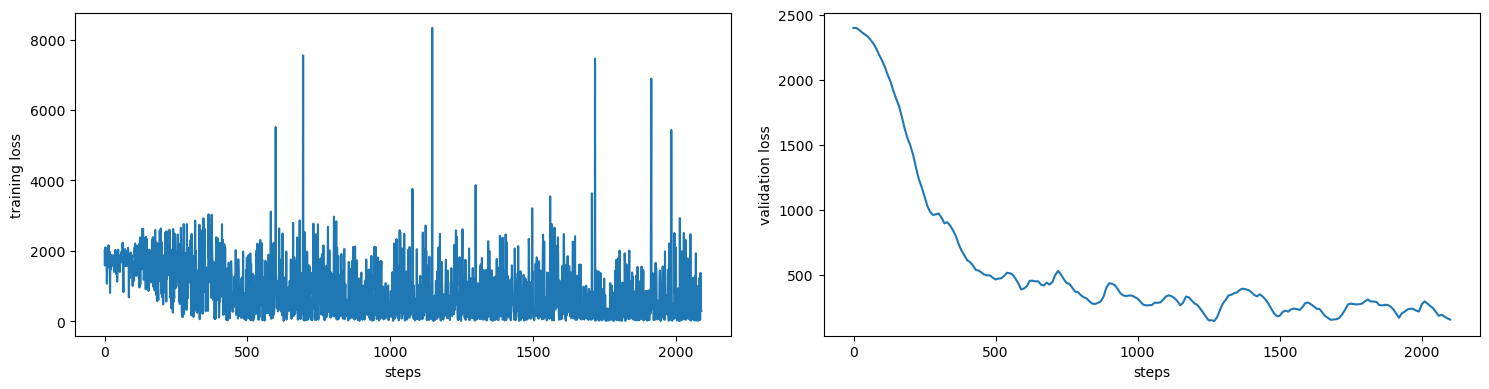

In [23]:
# Plot loss and validation checks
training_loss_log_np = [loss.detach().numpy() for loss in training_loss_log]
# evaluation_loss_log_np = [loss.detach().numpy() for loss in evaluation_loss_log]

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
_ = axs[0].plot(np.arange(len(training_loss_log_np)), training_loss_log_np)
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(evaluation_loss_log)) * 10, evaluation_loss_log)
_ = axs[1].set_xlabel('steps')
_ = axs[1].set_ylabel('validation loss')

_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()